## Score-based generative model for CMB lensing reconstruction
##### author: Thomas Flöss, 2024

In [1]:
import os
import jax.numpy as jnp
import numpy as np
import flax
import flax.linen as nn
from typing import Any, Tuple
import functools
from tqdm.notebook import tqdm, trange
import orbax
from flax.training import orbax_utils
import optax
import jax
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import optax
from flax.training import train_state
from flax.training import orbax_utils

from utils import PSFAST

import matplotlib as mpl
mpl.rc('image', cmap='RdBu_r')
plt.rcParams.update({'font.size': 14})

In [2]:
jax.local_device_count()

1

## Define some settings

In [3]:
grid = 256
typey = "1PARAM"
n_batches = 64

In [4]:
# Create an instance of PSFAST, used to compute power spectra etc.
powspec = PSFAST(grid,np.deg2rad(2./60.)*grid,fc=1.5,dk=1,Nbins=70)

grid 256
BoxSize 0.14893476283684945
kF 42.1875
Nyquist 5400.0
kmax in grid 7636.753
kmax 2995.3125


In [5]:
lowpass = (powspec.kgrid * powspec.kF < 3000.).astype(jnp.float32)

## Load training and validation data

##### training data can be generated using the accompanying notebook

In [6]:
train_dataset = np.zeros((n_batches*512,grid,grid,3),dtype=np.float32)

for i in tqdm(range(n_batches)):
    train_dataset[512*i:512*(i+1),:,:,0] = np.einsum("jki->ijk",np.load(f"/scratch/p301831/FlatLensingMaps/FlatLensingMaps_{typey}_Q_Lensed_{i}.npy"))
    train_dataset[512*i:512*(i+1),:,:,1] = np.einsum("jki->ijk",np.load(f"/scratch/p301831/FlatLensingMaps/FlatLensingMaps_{typey}_U_Lensed_{i}.npy"))
    ff = jnp.einsum("jki->ijk",np.load(f"/scratch/p301831/FlatLensingMaps/FlatLensingMaps_{typey}_Kappa_{i}.npy"))
    ff = jnp.fft.irfft2(jnp.fft.rfft2(ff) * lowpass)
    train_dataset[512*i:512*(i+1),:,:,2] = ff

  0%|          | 0/64 [00:00<?, ?it/s]

In [7]:
test_dataset = np.zeros((512,grid,grid,3),dtype=np.float32)
test_dataset[:,:,:,0] = np.einsum("jki->ijk",np.load(f"/scratch/p301831/FlatLensingMaps/FlatLensingMaps_{typey}_Q_Lensed_{n_batches}.npy"))
test_dataset[:,:,:,1] = np.einsum("jki->ijk",np.load(f"/scratch/p301831/FlatLensingMaps/FlatLensingMaps_{typey}_U_Lensed_{n_batches}.npy"))
ff = np.einsum("jki->ijk",np.load(f"/scratch/p301831/FlatLensingMaps/FlatLensingMaps_{typey}_Kappa_{n_batches}.npy"))
ff = jnp.fft.irfft2(jnp.fft.rfft2(ff) * lowpass)
test_dataset[:,:,:,2] = ff

In [27]:
val_dataset = np.zeros((1,grid,grid,3),dtype=np.float32)

val_dataset[:,:,:,0] = np.einsum("jki->ijk",np.load(f"data/FlatLensingMaps_{typey}_Q_Lensed_val_seed4.npy")[:,:,np.newaxis])
val_dataset[:,:,:,1] = np.einsum("jki->ijk",np.load(f"data/FlatLensingMaps_{typey}_U_Lensed_val_seed4.npy")[:,:,np.newaxis])
ff = np.einsum("jki->ijk",np.load(f"data/FlatLensingMaps_{typey}_Kappa_val_seed4.npy")[:,:,np.newaxis])
ff = jnp.fft.rfft2(ff) * lowpass
val_dataset[:,:,:,2] = jnp.fft.irfft2(ff)

val_QE = np.einsum("jki->ijk",np.load(f"data/FlatLensingMaps_{typey}_Kappa_QE_val_seed4.npy")[:,:,np.newaxis])
val_MAP = np.einsum("jki->ijk",np.load(f"data/FlatLensingMaps_{typey}_Kappa_MAP_val_seed4.npy")[:,:,np.newaxis])

In [9]:
# Load samples from a julia chain

samples_julia = np.einsum("ijk->kij",np.load(f"data/samples_julia_{typey}_seed4.npy"))
samples_julia = np.concatenate([jnp.fft.irfft2(jnp.fft.rfft2(samples_julia[128*i:128*(i+1)])*lowpass) for i in range(50)],axis=0)
samples_julia.shape

(3200, 256, 256)

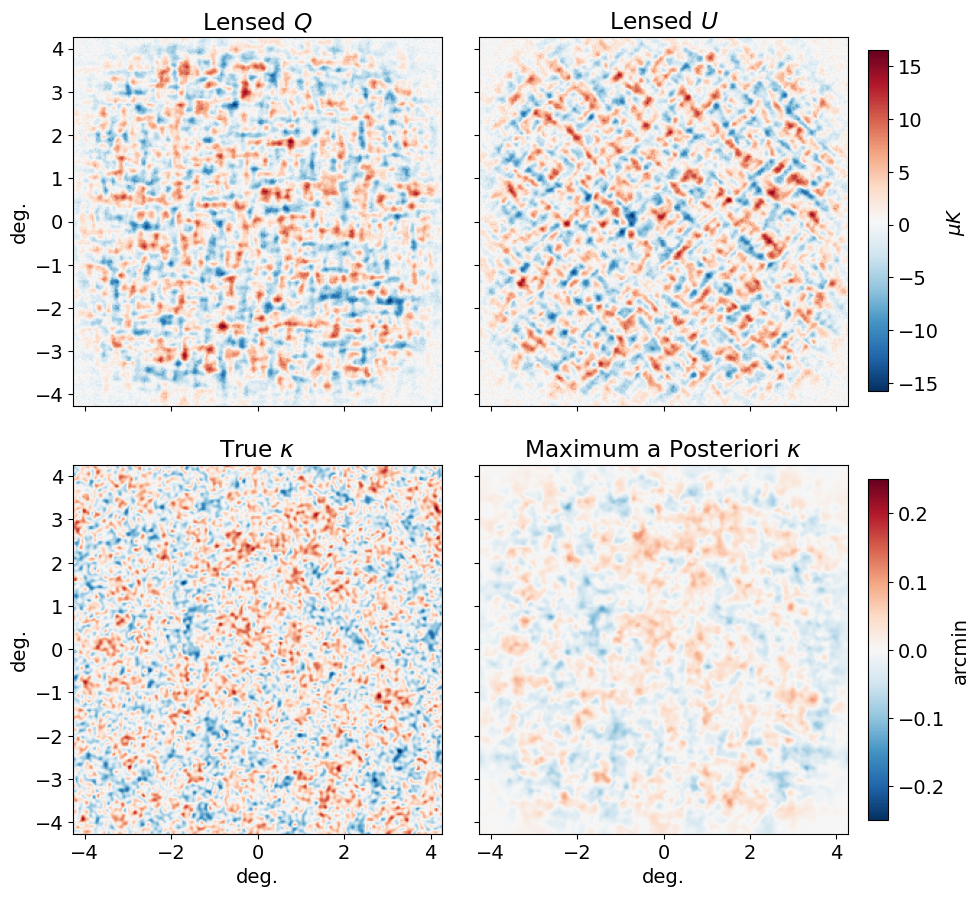

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 11),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.02)

im1 = axs[0, 0].imshow(val_dataset[-1,:,:,0],extent=(-1./60. * 256,1./60. * 256, -1./60. * 256,1./60. * 256))
axs[0, 0].set_title('Lensed $Q$')
axs[0, 0].set_ylabel('deg.')

im2 = axs[0, 1].imshow(val_dataset[-1,:,:,1],extent=(-1./60. * 256,1./60. * 256, -1./60. * 256,1./60. * 256))
axs[0, 1].set_title('Lensed $U$')

im3 = axs[1, 0].imshow(val_dataset[-1,:,:,2],vmin=-0.25,vmax=0.25, extent=(-1./60. * 256,1./60. * 256, -1./60. * 256,1./60. * 256))
axs[1, 0].set_title('True $\kappa$')
axs[1, 0].set_xlabel('deg.')
axs[1, 0].set_ylabel('deg.')

im4 = axs[1, 1].imshow(val_MAP[-1],vmin=-0.25,vmax=0.25,extent=(-1./60. * 256,1./60. * 256, -1./60. * 256,1./60. * 256))
axs[1, 1].set_title('Maximum a Posteriori $\kappa$')
axs[1, 1].set_xlabel('deg.')

cbar_ax1 = fig.add_axes([0.92, 0.535, 0.02, 0.31])  # Position for the first row colorbar
fig.colorbar(im1, cax=cbar_ax1,label='$\mu K$')

cbar_ax2 = fig.add_axes([0.92, 0.145, 0.02, 0.31])  # Position for the second row colorbar
fig.colorbar(im3, cax=cbar_ax2,label='arcmin')

plt.show()

In [11]:
# Normalize the data

for i in tqdm(range(3)):
    mean = train_dataset[:,:,:,i].mean()
    std =  train_dataset[:,:,:,i].std()
    print(mean,std)
    val_dataset[:,:,:,i] = (val_dataset[:,:,:,i] - mean)/std
    train_dataset[:,:,:,i] = (train_dataset[:,:,:,i] - mean)/std
    test_dataset[:,:,:,i] = (test_dataset[:,:,:,i] - mean)/std

  0%|          | 0/3 [00:00<?, ?it/s]

0.00017011605 3.7350185
7.932638e-05 3.734129
-1.4157564e-12 0.061670203


## Define the model's U-Net

In [12]:
class FourierDownsampling(nn.Module):
    """Performs downsampling in the Fourier domain."""
    @nn.compact
    def __call__(self, x):
        x = jnp.fft.rfft2(x,axes=(-3,-2),norm='forward')
        x = jnp.fft.fftshift(x, axes=(-3))
        new_shape = x.shape[-3]//4
        x = x[:,new_shape:3*new_shape,:new_shape+1,:]
        x = jnp.fft.ifftshift(x,axes=(-3))
        x = jnp.fft.irfft2(x,axes=(-3,-2),norm='forward')
        return x

class FourierUpsampling(nn.Module):
    """Performs upsampling (interpolation) in the Fourier domain."""
    @nn.compact
    def __call__(self, x):
        x = jnp.fft.rfft2(x,axes=(-3,-2),norm='forward')
        x = jnp.fft.fftshift(x, axes=(-3))
        new_shape = x.shape[-3]//2
        x = jnp.pad(x, pad_width=((0,0),(new_shape,new_shape),(0,new_shape),(0,0)))
        x = jnp.fft.ifftshift(x,axes=(-3))
        x = jnp.fft.irfft2(x,axes=(-3,-2),norm='forward')
        return x

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  embed_dim: int
  scale: float = 30.
  @nn.compact
  def __call__(self, x):
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    W = self.param('W', jax.nn.initializers.normal(stddev=self.scale),
                 (self.embed_dim // 2, ))
    W = jax.lax.stop_gradient(W)
    x_proj = x[:, None] * W[None, :] * 2 * jnp.pi
    return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  output_dim: int

  @nn.compact
  def __call__(self, x):
    return nn.Dense(self.output_dim)(x)[:, None, None, :]

class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture.
    
    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    marginal_prob_std: Any
    channels: Tuple[int] = (64, 64, 64, 64, 64, 64)
    embed_dim: int = 256
    padding: str = "CIRCULAR"
    
    @nn.compact
    def __call__(self, x, condition, t, train):
        act = nn.swish
        # Obtain the Gaussian random feature embedding for t
        embed = act(nn.Dense(self.embed_dim)(GaussianFourierProjection(embed_dim=self.embed_dim)(t)))

        # Encoding path
        h = jnp.concatenate([x,condition],axis=-1)
        res = nn.Conv(self.channels[0], (1, 1), (1, 1),)(h)
        
        h = nn.Conv(self.channels[0], (3, 3), (1, 1), padding=self.padding,)(h)
        h += Dense(self.channels[0])(embed)
        h = nn.GroupNorm(4)(h)
        h = act(h)
        
        h = nn.Conv(self.channels[0], (3, 3), (1, 1), padding=self.padding,)(h)
        h += Dense(self.channels[0])(embed)
        h = nn.GroupNorm(4)(h)
        h = act(h)
        h = (h + res)/jnp.sqrt(2.)

        skips = []
        
        for channel in self.channels[1:]:
            skips.append(h)
            
            h = FourierDownsampling()(h)
            res =  nn.Conv(channel, (1, 1), (1, 1),)(h)

            h = nn.Conv(channel, (3, 3), (1, 1), padding=self.padding,)(h)
            h += Dense(channel)(embed)
            h = nn.GroupNorm(4)(h)
            h = act(h)

            h = nn.Conv(channel, (3, 3), (1, 1), padding=self.padding,)(h)
            h += Dense(channel)(embed)
            h = nn.GroupNorm(4)(h)
            h = act(h)
            
            h = (h + res)/jnp.sqrt(2.)

        for i in range(len(self.channels[:-1])):
            channel = self.channels[:-1][::-1][i]
            
            h = FourierUpsampling()(h)
            h = (jnp.concatenate([h, skips[::-1][i]], axis=-1))
            res = nn.Conv(channel, (1, 1), (1, 1),)(h)
            
            h = nn.Conv(channel, (3, 3), (1, 1), padding=self.padding,)(h)
            h += Dense(channel)(embed)
            h = nn.GroupNorm(4)(h)
            h = act(h)
            
            h = nn.Conv(channel, (3, 3), (1, 1), padding=self.padding,)(h)
            h += Dense(channel)(embed)
            h = nn.GroupNorm(4)(h)
            h = act(h)
            
            h = (h + res)/jnp.sqrt(2.)
        
        h = nn.Conv(1, (1, 1), (1, 1), padding=self.padding)(h)
        h = h / self.marginal_prob_std(t)[:, None, None, None]

        return h

In [13]:
sigma_min = 1e-2
sigma_max = 100

def marginal_prob_std(t, sigma_min=sigma_min, sigma_max=sigma_max):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  return sigma_min * (sigma_max / sigma_min) ** t

def diffusion_coeff(t, sigma_min=sigma_min,sigma_max=sigma_max):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  sigma = sigma_min * (sigma_max / sigma_min) ** t
  return sigma * jnp.sqrt(2 * (jnp.log(sigma_max) - jnp.log(sigma_min)))

In [14]:
batch_size =  64*jax.device_count()
rng = jax.random.PRNGKey(2)
score_model = ScoreNet(marginal_prob_std,)

### Set up the lensing power spectrum for tilting the noise and visualize the noise schedule

In [15]:
C_ell = np.load("data/C_ell.npy") / std / std
Cgrid = jnp.interp(powspec.kgrid * powspec.kF, np.arange(2,10000),C_ell,left=1.)
Cgrid *= lowpass
Cgrid *= 1/(np.deg2rad(2./60.)**2.)
Cgrid = Cgrid.at[0,0].set(1.)
Cgrid_sqrt = jnp.sqrt(Cgrid)

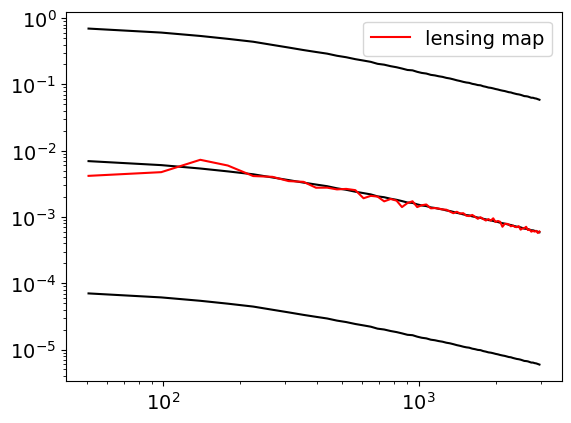

In [16]:
# Visualize the noise levels we are using
rng, step_rng = jax.random.split(rng)
z = jax.random.normal(step_rng, (64,256,256))

z = jnp.fft.rfft2(z,axes=(1,2)) * Cgrid_sqrt
z = jnp.fft.irfft2(z,axes=(1,2))

plt.loglog(powspec.k_means, powspec.Pk(z*marginal_prob_std(1e-3)).mean(0)**.5,"k")
plt.loglog(powspec.k_means, powspec.Pk(z*marginal_prob_std(.5)).mean(0)**.5,"k")
plt.loglog(powspec.k_means, powspec.Pk(z*marginal_prob_std(1.)).mean(0)**.5,"k")

plt.plot(powspec.k_means,powspec.Pk(train_dataset[:1,:,:,-1])[0]**.5,"red",label="lensing map")
plt.legend()
plt.show()

## Define the model and training algorithm

In [17]:
learning_rate = 0.00001
ema = optax.ema(0.9999,debias=False)

@functools.partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def init_train_state(rng, model, learning_rate) -> train_state.TrainState:
    fake_input = jnp.ones((batch_size, 256, 256, 1))
    fake_condition = jnp.ones((batch_size, 256, 256, 2))
    fake_time = jnp.ones(batch_size)
    rng, step_rng = jax.random.split(rng)
    variables = model.init(step_rng, fake_input, fake_condition, fake_time,train=False)
    optimizer = optax.chain(optax.clip_by_global_norm(1.),optax.adamw(learning_rate))

    state = train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params'],
    )

    ema_state = ema.init(state.params)
    
    return state, ema_state

state, ema_state = init_train_state(jax.random.split(rng,jax.local_device_count()) , score_model, learning_rate)

In [24]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
checkpoint_file = f'Model_{typey}'

checkpoint_file, checkpoint_file+"_spare"

('Model_1PARAM', 'Model_1PARAM_spare')

In [25]:
# Run the first time to create a checkpoint

# ckpt = {'model' : flax.jax_utils.unreplicate(state), "ema" : flax.jax_utils.unreplicate(ema_state)}
# save_args = orbax_utils.save_args_from_target(ckpt)
# orbax_checkpointer.save(checkpoint_file, ckpt, save_args=save_args)

In [26]:
# Load weights

try:
    target = {'model' : state, 'ema' : ema_state}
    load_state = orbax_checkpointer.restore(checkpoint_file,item=target)
    
    state = flax.jax_utils.replicate(load_state['model'])
    ema_state = flax.jax_utils.replicate(load_state['ema'])
    
    print(state.step[0])
except:
    target = {'model' : state, 'ema' : ema_state}
    load_state = orbax_checkpointer.restore(checkpoint_file+"_spare",item=target)
    
    state = flax.jax_utils.replicate(load_state['model'])
    ema_state = flax.jax_utils.replicate(load_state['ema'])
    
    print(state.step[0])

220004


In [41]:
# To override the EMA weights with the latest weights

# _, ema_state = optax.ema(0.,debias=False).update(state.params, ema_state)

# To override the weights with the EMA weights

# state.params.update(ema_state.ema)

In [42]:
@functools.partial(jax.pmap, axis_name='device')
def train_step(rng, state: train_state.TrainState, ema_state, x: jnp.ndarray,condition: jnp.ndarray):

    def loss_fn(rng, params, x, condition, marginal_prob_std, eps=9e-4):
        """The loss function for training score-based generative models.
        Args:
        model: A `flax.linen.Module` object that represents the structure of
          the score-based model.
        params: A dictionary that contains all trainable parameters.
        x: A mini-batch of training data.
        marginal_prob_std: A function that gives the standard deviation of
          the perturbation kernel.
        eps: A tolerance value for numerical stability.
        """
        rng, step_rng = jax.random.split(rng)
        
        z_w = jax.random.normal(step_rng, x.shape)
        z_w = jnp.fft.rfft2(z_w,axes=(1,2)) * lowpass[None,:,:,None]
        z = z_w * Cgrid_sqrt[None,:,:,None]
        z_w = jnp.fft.irfft2(z_w,axes=(1,2))
        z = jnp.fft.irfft2(z,axes=(1,2))

        rng, step_rng = jax.random.split(rng)
        random_t = jax.random.uniform(step_rng, (x.shape[0],), minval=eps, maxval=1.001)
        std = marginal_prob_std(random_t)
        rng, step_rng = jax.random.split(rng)
        perturbed_x = x + z * std[:, None, None, None]
        
        score = state.apply_fn({'params': params,}, perturbed_x, condition, random_t, train=True)
        score = jnp.fft.rfft2(score,axes=(1,2)) * lowpass[None,:,:,None]
        score = jnp.fft.irfft2(score,axes=(1,2))

        loss = (score * std[:, None, None, None] + z_w)**2
        loss = jnp.mean(jnp.sum(loss,axis=(1,2,3)))
        
        return loss
    
    gradient_fn = jax.value_and_grad(loss_fn,argnums=(1))
    rng, step_rng = jax.random.split(rng)
    loss, grads = gradient_fn(step_rng, state.params, x, condition, marginal_prob_std)
    mean_grad = jax.lax.pmean(grads, axis_name='device')
    mean_loss = jax.lax.pmean(loss, axis_name='device')
    state = state.apply_gradients(grads=mean_grad)
    _, ema_state = ema.update(state.params, ema_state)
    return state, ema_state, mean_loss

In [43]:
assert batch_size % jax.local_device_count() == 0
data_shape = (jax.local_device_count(), -1, 256, 256, 3)

data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
data_shape

(1, -1, 256, 256, 3)

In [ ]:
n_epochs = 10000
tqdm_epoch = tqdm(range(n_epochs))

for epoch in tqdm_epoch:
    tqdm_epoch.set_description(f"Steps: {state.step[0]}")
    avg_loss = 0.
    num_items = 0
    tqdm_loader = tqdm(data_loader)
    for x in tqdm_loader:
        x= x.numpy().reshape(data_shape)

        rng, step_rng = jax.random.split(rng)
        flip_rand = jax.random.randint(step_rng,[2],minval=0,maxval=2)
        if flip_rand[0] == 1:
            x = np.flip(x,axis=2)
        if flip_rand[1] == 1:
            x = np.flip(x,axis=3)
            
        condition = x[:,:,:,:,:2]
        x = x[:,:,:,:,-1:]
        rng, *step_rng = jax.random.split(rng,jax.device_count()+1)
        step_rng = jnp.asarray(step_rng)
        state, ema_state, loss = train_step(step_rng, state, ema_state, x, condition)
        avg_loss += loss[0] / 256**2. * batch_size
        num_items += batch_size
        tqdm_loader.set_description('Epoch {:1}, Average Loss: {:5f}'.format(epoch,avg_loss / num_items))

    ckpt = {'model' : flax.jax_utils.unreplicate(state), "ema" : flax.jax_utils.unreplicate(ema_state)}
    save_args = orbax_utils.save_args_from_target(ckpt)

    orbax_checkpointer.save(checkpoint_file, ckpt, save_args=save_args, force=True)
    orbax_checkpointer.save(checkpoint_file+"_spare", ckpt, save_args=save_args, force=True)

## Once trained, we can sample from the model

In [44]:
target = {'model' : state, 'ema' : ema_state}
load_state = orbax_checkpointer.restore(checkpoint_file,item=target)

state = flax.jax_utils.replicate(load_state['model'])
ema_state = flax.jax_utils.replicate(load_state['ema'])

print(state.step[0])

220004


In [66]:
def Euler_Maruyama_sampler(rng,condition,state,ema_state,batch_size=1024,num_steps=1000,eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.
    
    Args:
    rng: A JAX random state.
    score_model: A `flax.linen.Module` object that represents the architecture
      of a score-based model.
    params: A dictionary that contains the model parameters.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    eps: The smallest time step for numerical stability.
    
    Returns:
    Samples.
    """
    time_shape = (jax.local_device_count(), batch_size // jax.local_device_count())
    sample_shape = time_shape + (256, 256, 1)
    
    rng, step_rng = jax.random.split(rng)
    time_steps = jnp.linspace(1., eps, num_steps+1)
    
    init_x = jax.random.normal(step_rng, sample_shape)
    init_x = jnp.fft.rfft2(init_x,axes=(2,3)) * Cgrid_sqrt[None,None,:,:,None]
    init_x = jnp.fft.irfft2(init_x,axes=(2,3))
    init_x *= marginal_prob_std(1.)
    condition = jnp.repeat(condition,batch_size,axis=0).reshape(jax.device_count(),-1,256,256,2)
    x = init_x
    
    step_size = time_steps[0] - time_steps[1]

    @functools.partial(jax.pmap, axis_name='device')
    def diffusion_step(rng,state,ema_state,x,condition,batch_time_step):
        g = diffusion_coeff(batch_time_step[0])
        score = state.apply_fn({'params': ema_state.ema},x,condition,batch_time_step,train=False)
        score = jnp.fft.rfft2(score,axes=(1,2)) * Cgrid_sqrt[None,:,:,None]
        score = jnp.fft.irfft2(score,axes=(1,2))
        mean_x = x + (g**2) * score * step_size
        rng, step_rng = jax.random.split(rng)
        z = jax.random.normal(step_rng, x.shape)
        z = jnp.fft.rfft2(z,axes=(1,2)) * Cgrid_sqrt[None,:,:,None]
        z = jnp.fft.irfft2(z,axes=(1,2))
        x = mean_x + jnp.sqrt(step_size) * g * z
        return rng, x, mean_x

    rng, *step_rng = jax.random.split(rng,jax.device_count()+1)
    step_rng = jnp.asarray(step_rng)

    for i in tqdm(range(len(time_steps)-1),leave=True,desc=f"Sampling {batch_size} realizations"):
        time_step = time_steps[i]
        time_step = jnp.ones(time_shape) * time_step
        step_rng, x, mean_x = diffusion_step(step_rng,state,ema_state,x,condition,time_step)

    mean_x = mean_x * std + mean
    plt.imshow(mean_x[0,0],vmin=-0.25,vmax=0.25)
    plt.colorbar()
    plt.show()
    return np.asarray(mean_x.reshape(-1,256,256))

0.0009989738


Sampling 16 realizations:   0%|          | 0/1000 [00:00<?, ?it/s]

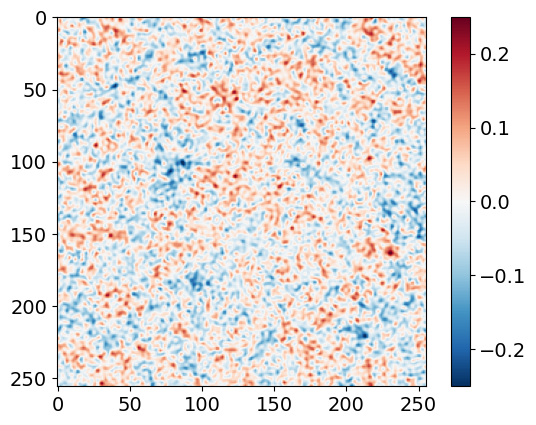

In [67]:
num_steps = 1000
rng, step_rng = jax.random.split(rng)
samples_full = np.concatenate([Euler_Maruyama_sampler(step_rng*(i+1),val_dataset[:1,:,:,:2],state,ema_state,batch_size=16*jax.device_count(),num_steps=num_steps,eps=1e-3) for i in range(1)])

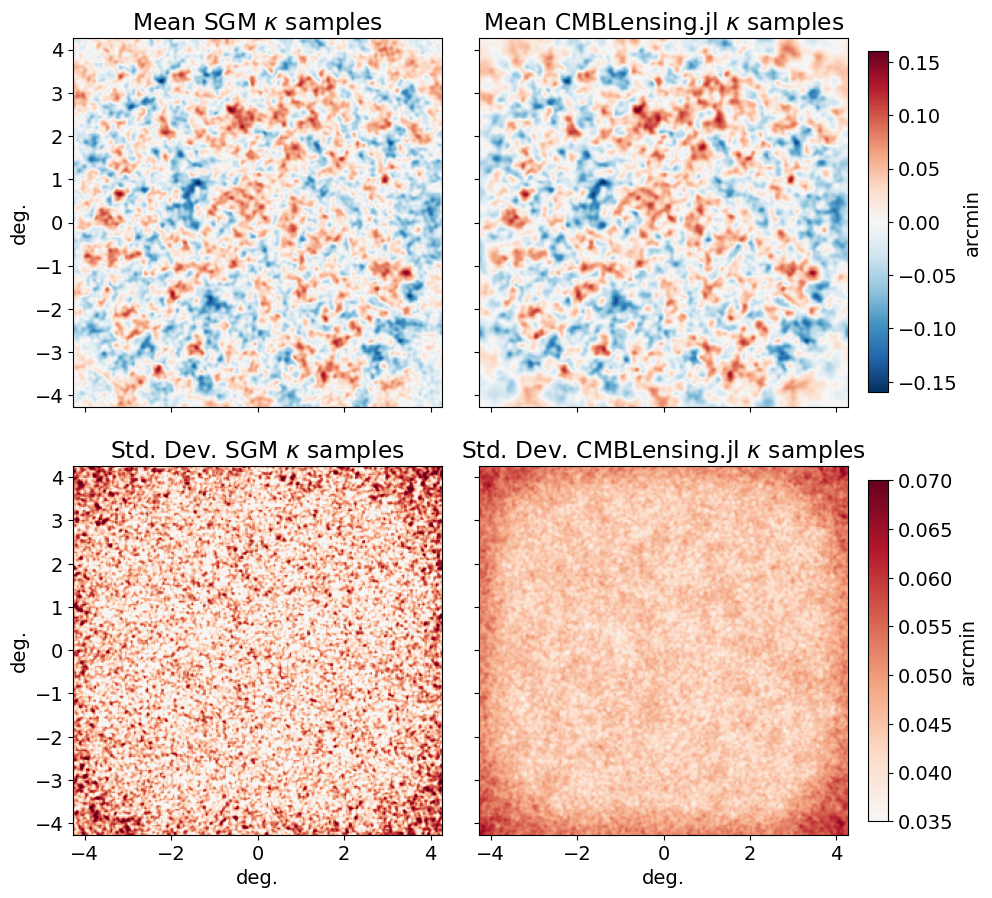

In [68]:
from matplotlib.colors import LinearSegmentedColormap

original_cmap = plt.cm.RdBu_r
new_cmap = LinearSegmentedColormap.from_list(
    "upper_half", original_cmap(np.linspace(0.5, 1, 256))
)

fig, axs = plt.subplots(2, 2, figsize=(10, 11),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.02)

im1 = axs[0, 0].imshow(samples_full.mean(0),vmin=-0.16,vmax=0.16,extent=(-1./60. * 256,1./60. * 256, -1./60. * 256,1./60. * 256))
axs[0, 0].set_title('Mean SGM $\\kappa$ samples')
axs[0, 0].set_ylabel('deg.')

im2 = axs[0, 1].imshow(samples_julia.mean(0),vmin=-0.16,vmax=0.16,extent=(-1./60. * 256,1./60. * 256, -1./60. * 256,1./60. * 256))
axs[0, 1].set_title('Mean CMBLensing.jl $\\kappa$ samples')

im3 = axs[1, 0].imshow((samples_full).std(0),vmin=0.035,vmax=0.07,extent=(-1./60. * 256,1./60. * 256, -1./60. * 256,1./60. * 256),cmap=new_cmap)
axs[1, 0].set_title('Std. Dev. SGM $\\kappa$ samples')
axs[1, 0].set_xlabel('deg.')
axs[1, 0].set_ylabel('deg.')

im4 = axs[1, 1].imshow((samples_julia).std(0),vmin=0.035,vmax=0.07,extent=(-1./60. * 256,1./60. * 256, -1./60. * 256,1./60. * 256),cmap=new_cmap)
axs[1, 1].set_title('Std. Dev. CMBLensing.jl $\\kappa$ samples')
axs[1, 1].set_xlabel('deg.')

cbar_ax1 = fig.add_axes([0.92, 0.535, 0.02, 0.31])  
fig.colorbar(im1, cax=cbar_ax1,label='arcmin')

cbar_ax2 = fig.add_axes([0.92, 0.145, 0.02, 0.31])
fig.colorbar(im3, cax=cbar_ax2,label='arcmin')

plt.show()

## Analyse the samples

In [69]:
Pk_theory = np.concatenate([powspec.Pk(train_dataset[i*128:128*(i+1),:,:,-1]*std + mean) for i in range(32)]).mean(0)
Pk_true = powspec.Pk(val_dataset[:1,:,:,-1]*std + mean)[0]

Pk_sample_julia = np.concatenate([powspec.Pk(samples_julia[i*128:128*(i+1)]) for i in range(28)])
Pk_sample_full = np.concatenate([powspec.Pk(samples_full[i*128:128*(i+1)]) for i in range(28)])

Pk_MAP_jl = powspec.Pk(val_MAP)[0]
Pk_MOP_jl = powspec.Pk(samples_julia.mean(0,keepdims=True))[0]
Pk_MOP_full = powspec.Pk(samples_full.mean(0,keepdims=True))[0]
Pk_QE = powspec.Pk(val_QE.mean(0,keepdims=True))[0]

Ck_MAP_jl = powspec.Ck(val_dataset[:1,:,:,-1],val_MAP)[0]
Ck_MOP_jl = powspec.Ck(val_dataset[:1,:,:,-1],samples_julia.mean(0,keepdims=True))[0]
Ck_MOP_full = powspec.Ck(val_dataset[:1,:,:,-1],samples_full.mean(0,keepdims=True))[0]
Ck_QE = powspec.Ck(val_dataset[:1,:,:,-1],val_QE[:1])[0]

Ck_sample_julia = np.concatenate([powspec.Ck(samples_julia[i*128:128*(i+1)],val_dataset[:1,:,:,-1]) for i in range(28)])
Ck_sample_full = np.concatenate([powspec.Ck(samples_full[i*128:128*(i+1)],val_dataset[:1,:,:,-1]) for i in range(28)])

Pk_noise_julia = np.concatenate([powspec.Pk(samples_julia[i*128:128*(i+1)] - (val_dataset[:1,:,:,-1]*std + mean)) for i in range(28)])
Pk_noise_full = np.concatenate([powspec.Pk(samples_full[i*128:128*(i+1)] - (val_dataset[:1,:,:,-1]*std + mean)) for i in range(28)])

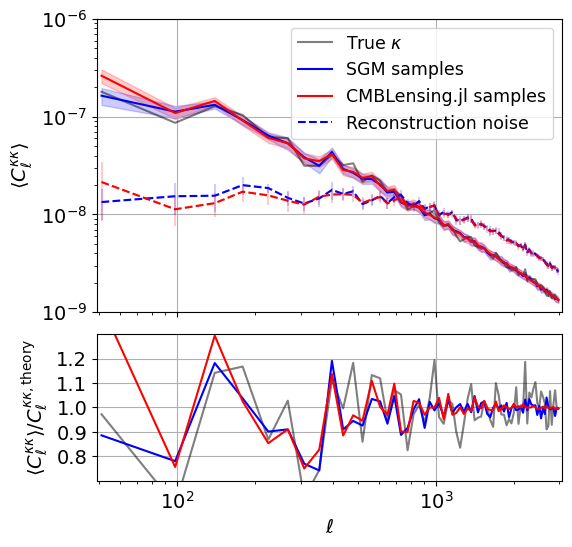

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.1})

ax1.loglog(powspec.k_means, 1.0 * Pk_true, "k",label='True $\kappa$',alpha=.5)
ax1.loglog(powspec.k_means, Pk_sample_full.mean(0),"b",label="SGM samples")
ax1.fill_between(powspec.k_means, Pk_sample_full.mean(0) - Pk_sample_full.std(0), Pk_sample_full.mean(0) + Pk_sample_full.std(0),color="b",alpha=0.2)
ax1.loglog(powspec.k_means, Pk_sample_julia.mean(0),"r",label="CMBLensing.jl samples")
ax1.fill_between(powspec.k_means, Pk_sample_julia.mean(0) - Pk_sample_julia.std(0), Pk_sample_julia.mean(0) + Pk_sample_julia.std(0),color="r",alpha=0.2)

ax1.plot(powspec.k_means,Pk_noise_full.mean(0),"b--",label='Reconstruction noise')
ax1.plot(powspec.k_means,Pk_noise_julia.mean(0),"r--")
ax1.errorbar(powspec.k_means,Pk_noise_full.mean(0),yerr=Pk_noise_full.std(0),color='blue',linestyle="--",alpha=.2)
ax1.errorbar(powspec.k_means,Pk_noise_julia.mean(0),yerr=Pk_noise_julia.std(0),color='red',linestyle="--",alpha=.2)

ax1.set_xlim(powspec.k_means[0]-2,powspec.k_means[-1]+100)
ax1.grid()
ax1.legend(fontsize=12.5)
ax1.set_ylabel('$\\langle C^{\kappa \kappa}_{\ell}\\rangle$')
ax1.set_ylim(1e-9,1e-6)

ax2.plot(powspec.k_means, Pk_true / Pk_theory , "k",alpha=.5)
ax2.plot(powspec.k_means, Pk_sample_full.mean(0) / (1.0 * Pk_theory), "b")
ax2.plot(powspec.k_means, Pk_sample_julia.mean(0) / (1.0 * Pk_theory) , "r")

# ax2.legend()
ax2.set_ylim(0.7,1.3)
ax2.set_yticks([0.8,0.9,1.0,1.1,1.2],[0.8,0.9,1.0,1.1,1.2])
ax2.grid()
ax2.set_xlabel('$\ell$')
ax2.set_ylabel('$\\langle C^{\kappa \kappa}_{\ell} \\rangle / C^{\kappa \kappa,\\rm{theory}}_{\ell}$')

plt.show()

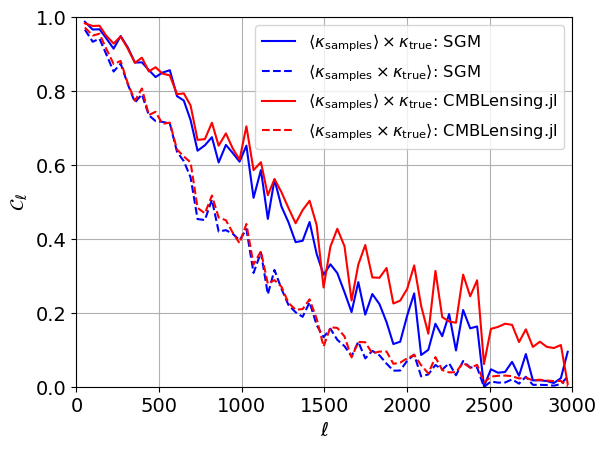

In [71]:
plt.plot(powspec.k_means,Ck_MOP_full,"blue",label="$\\langle \kappa_{\\rm samples}\\rangle \\times \kappa_{\\rm true}$: SGM")
plt.plot(powspec.k_means,Ck_sample_full.mean(0),"b--",label="$\\langle \kappa_{\\rm samples}\\times \kappa_{\\rm true} \\rangle$: SGM")
plt.plot(powspec.k_means,Ck_MOP_jl,"red",label="$\\langle \kappa_{\\rm samples}\\rangle \\times \kappa_{\\rm true}$: CMBLensing.jl")
plt.plot(powspec.k_means,Ck_sample_julia.mean(0),"r--",label="$\\langle \kappa_{\\rm samples}\\times \kappa_{\\rm true} \\rangle$: CMBLensing.jl")

plt.ylim(0,1)
plt.xlim(0,3000)
plt.xlabel("$\\ell$")
plt.ylabel("$\mathcal{C}_{\ell}$")
plt.legend(fontsize=11.8)
plt.grid()
plt.show()